# Merging labels

From the confusion matrix we saw that certain tuples of behaviours have a tendency to be mixed up with each other. Interestingly, they are also seemingly in similar branches of the hierarchical behaviour tree, so we want to try if the overall performance of the model improves if we specifically merge those label into more generic labels.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import preprocessing, metrics
import scikitplot as skplt
from sklearn.metrics import classification_report, roc_auc_score, plot_confusion_matrix
import matplotlib.pyplot as plt
import pickle
from sklearn.tree import DecisionTreeClassifier
from tsai.all import *

Merging the labels

In [ ]:
df = pd.read_hdf("merged_20210405.h5")
df = df[(df['behavior'] != "not_defined")]

In [ ]:
df.loc[(df['behavior'] == "back_preening") | (df['behavior'] == "front_preening"), 'behavior'] = "preening"
df.loc[(df['behavior'] == "standing_shaking") | (df['behavior'] == "scratch_with_feet"), 'behavior'] = "standing"
df.loc[(df['behavior'] == "body_pump") | (df['behavior'] == "feather_clapping"), 'behavior'] = "fluffing"

In [ ]:
df['behavior'].unique()

array(['head_shake', 'tail_shake', 'preening', 'standing', 'eating',
       'fluffing', 'walking'], dtype=object)

In [ ]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]

y = df['behavior']
x = df[features].values

In [ ]:
clf = RandomForestClassifier(random_state=0, verbose=1)
scores = cross_val_score(clf, x, y, n_jobs=-1)
print(scores)

[0.79474323 0.76323725 0.68295304 0.83460132 0.82177125]


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state=13, shuffle=False)
clf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 13.8min finished


RandomForestClassifier(random_state=0, verbose=1)

In [ ]:
predictions = clf.predict(x_valid)
print(classification_report(y_valid, predictions))
print(roc_auc_score(y_valid, clf.predict_proba(x_valid), multi_class='ovo', average='macro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished


              precision    recall  f1-score   support

      eating       0.99      0.97      0.98     66299
    fluffing       0.91      0.76      0.83     11791
  head_shake       0.02      0.06      0.03      1589
    preening       0.41      0.72      0.53      8787
    standing       0.88      0.81      0.84     76503
  tail_shake       0.39      0.18      0.25      1755
     walking       0.51      0.49      0.50      6386

    accuracy                           0.84    173110
   macro avg       0.59      0.57      0.56    173110
weighted avg       0.87      0.84      0.85    173110



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished


0.9125805707142718


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished


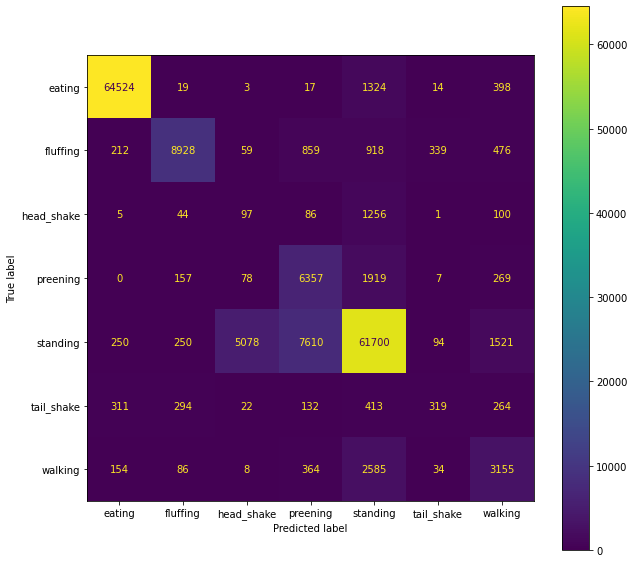

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, x_valid, y_valid, ax=ax) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished


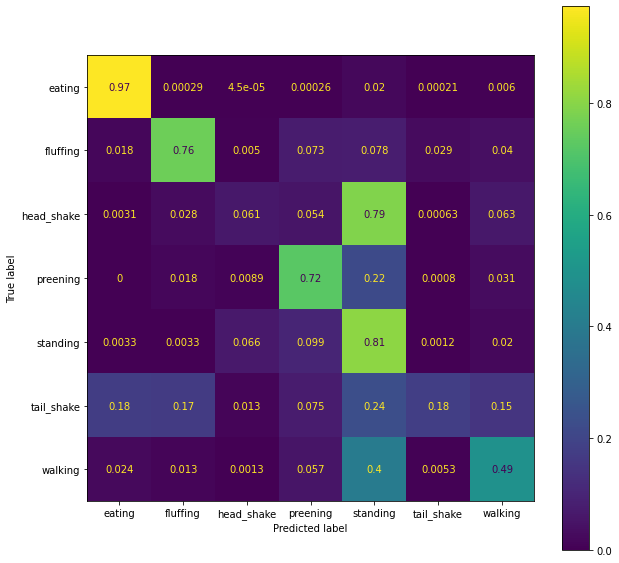

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, x_valid, y_valid, normalize='true', ax=ax) 

In [ ]:
filename = 'random_forest_merge.sav'
pickle.dump(clf, open(filename, 'wb'))

# Multiple Frames in Input Vector

In [ ]:
from joblib import Parallel, delayed
def create_ts(windows_size):
    def y_func(o): 
        return scipy.stats.mode(o, axis=1).mode.ravel()

    x_ts, y_ts = SlidingWindow(windows_size, get_x=features, get_y='behavior', y_func=y_func)(df)
    x_ts = x_ts.reshape((-1, x_ts.shape[1] * x_ts.shape[2]))
    x_ts_train, x_ts_valid, y_ts_train, y_ts_valid = train_test_split(x_ts, y_ts, test_size = 0.2, random_state=13, shuffle=False)
    
    return  x_ts_train, x_ts_valid, y_ts_train, y_ts_valid

def split_and_train(i):
    x_train, x_valid, y_train, y_valid = create_ts(i)
    clf = RandomForestClassifier(random_state=0)
    clf.fit(x_train, y_train)
    return (clf, x_valid, y_valid)

classifiers = Parallel(n_jobs=2, verbose=10)(delayed(split_and_train)(i) for i in [8, 16])


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 117.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 117.4min finished


In [ ]:
classifiers

[(RandomForestClassifier(random_state=0),
  array([[  8.94227649,   8.93779653,   8.56780726, ..., -55.06174654,
          -55.7520428 , -57.75128586],
         [  8.93779653,   8.56780726,   8.18832869, ..., -55.7520428 ,
          -57.75128586, -58.75179937],
         [  8.56780726,   8.18832869,   7.59697982, ..., -57.75128586,
          -58.75179937, -59.82770648],
         ...,
         [ 29.20542367,  26.92705089,  17.13764573, ..., -70.09002238,
          -72.89491935, -73.79030663],
         [ 26.92705089,  17.13764573,  13.06688838, ..., -72.89491935,
          -73.79030663, -74.75503846],
         [ 17.13764573,  13.06688838,   1.76277981, ..., -73.79030663,
          -74.75503846, -72.10899918]]),
  array(['standing', 'standing', 'standing', ..., 'head_shake',
         'head_shake', 'head_shake'], dtype=object)),
 (RandomForestClassifier(random_state=0),
  array([[  8.09924555,   8.76937308,   8.69344929, ..., -55.7520428 ,
          -57.75128586, -58.75179937],
         [  

In [ ]:

for c in classifiers:
    predictions = c[0].predict(c[1])
    print(classification_report(c[2], predictions))

              precision    recall  f1-score   support

      eating       0.99      0.97      0.98     66299
    fluffing       0.93      0.75      0.83     11791
  head_shake       0.02      0.07      0.03      1589
    preening       0.39      0.73      0.51      8787
    standing       0.87      0.79      0.83     76501
  tail_shake       0.56      0.20      0.30      1755
     walking       0.52      0.45      0.48      6386

    accuracy                           0.83    173108
   macro avg       0.61      0.57      0.57    173108
weighted avg       0.87      0.83      0.85    173108

              precision    recall  f1-score   support

      eating       0.99      0.97      0.98     66299
    fluffing       0.93      0.74      0.82     11791
  head_shake       0.01      0.05      0.02      1589
    preening       0.58      0.72      0.64      8787
    standing       0.87      0.83      0.85     76500
  tail_shake       0.52      0.18      0.27      1755
     walking       0.32 

# Cross-fold on best frame size

Doing cross-fold validation using a score that is more useful than just accuracy (e.g. f1?).

# Plot Split


In [ ]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 1000000])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

<AxesSubplot:title={'center':'StratifiedKFold'}, xlabel='Sample index', ylabel='CV iteration'>

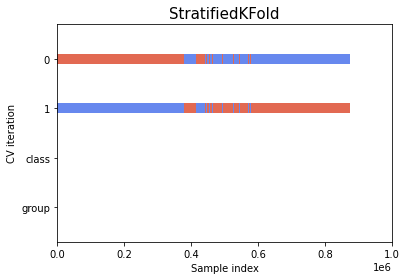

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
fig, ax = plt.subplots()
cv = StratifiedKFold(2)
plot_cv_indices(cv, x, y, ax, 2)